<a href="https://colab.research.google.com/github/Shashank65536/LinearRegression/blob/main/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd


In [ ]:
file_path = 'historical_data.csv'
data = pd.read_csv(file_path)

#Data Cleaning

In [ ]:
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])

data['delivery_duration_minutes'] = ((data['actual_delivery_time'] - data['created_at']).dt.total_seconds())/60

data.dropna(subset=['delivery_duration_minutes'], inplace=True)

data.drop(columns=['created_at', 'actual_delivery_time'], inplace=True)

for column in data.select_dtypes(include=['float64', 'int64']).columns:
    data[column].fillna(data[column].median(), inplace=True)
for column in data.select_dtypes(include=['object']).columns:
    data[column].fillna('', inplace=True)

data['total_busy_dashers'] = abs(data['total_busy_dashers'])
data['total_onshift_dashers'] = abs(data['total_onshift_dashers'])

data = data[data['total_onshift_dashers'] != 0]

data['dashers_availability_percent'] = ((data['total_onshift_dashers'] - data['total_busy_dashers'])/data['total_onshift_dashers'])*100



<ipython-input-64-f08bcc8a935a>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dashers_availability_percent'] = ((data['total_onshift_dashers'] - data['total_busy_dashers'])/data['total_onshift_dashers'])*100


In [ ]:
len_before_outliers = len(data)

def find_outliers(df, variable, distance):

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    df = df[(df[variable] > lower_boundary) &  (df[variable] < upper_boundary)]

    return df

data = find_outliers(data, 'subtotal', 1.5).sort_values(by = ['subtotal'])
data = find_outliers(data, 'delivery_duration_minutes', 1.5).sort_values(by = ['delivery_duration_minutes'])
data = find_outliers(data, 'max_item_price', 1.5).sort_values(by = ['delivery_duration_minutes'])

print(f"Length Before Outliers: {len_before_outliers}")
print(f"Length after Outliers Dropped: {len(data)}")

Length Before Outliers: 193806
Length after Outliers Dropped: 172397


In [ ]:
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_columns', None)

le = LabelEncoder()

for cat_var in ['store_primary_category']:
    data[cat_var] = le.fit_transform(data[cat_var])

In [ ]:
data = data.dropna(how='any',axis=0)


In [ ]:
data.columns

Index(['market_id', 'store_id', 'store_primary_category', 'order_protocol',
       'total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
       'max_item_price', 'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration',
       'delivery_duration_minutes', 'dashers_availability_percent'],
      dtype='object')

In [ ]:
data = data.drop(columns = ['min_item_price','num_distinct_items','order_protocol',
                            'total_onshift_dashers','total_busy_dashers'])

In [ ]:
data.to_csv('cleaned_data.csv', index=False)

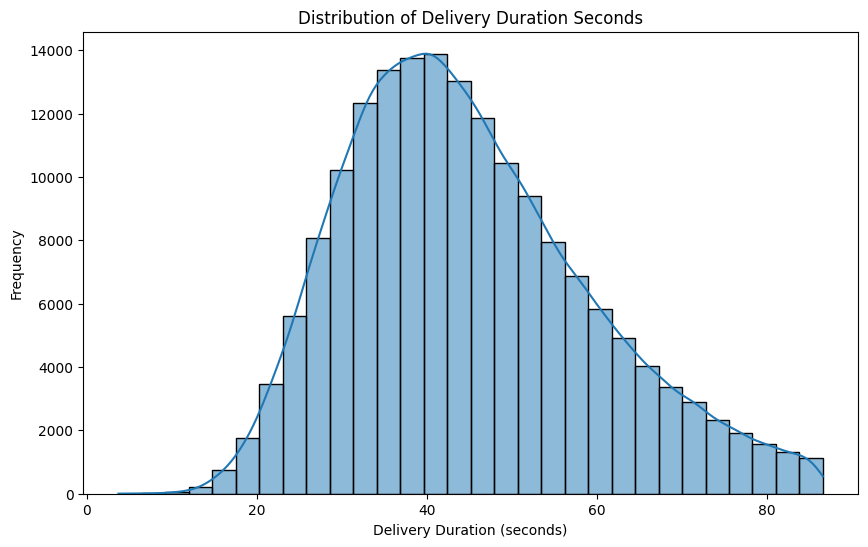

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data['delivery_duration_minutes'], bins=30, kde=True)
plt.title('Distribution of Delivery Duration Seconds')
plt.xlabel('Delivery Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# import numpy as np
# data = pd.read_csv('cleaned_data.csv')

# X = data.drop(columns=['delivery_duration_minutes'])
# y = data['delivery_duration_minutes']


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = LinearRegression()
# model.fit(X_train,y_train)

# test_predictions = model.predict(X_test)

# MSE = mean_squared_error(y_test,test_predictions)
# RMSE = np.sqrt(MSE)

# print(f"MSE: {MSE}")
# print(f"RMSE: {RMSE}")

MSE: 174.03257774570235
RMSE: 13.19214075674234


#Data Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

data = pd.read_csv('cleaned_data.csv')

X = data.drop(columns=['delivery_duration_minutes'])
y = data['delivery_duration_minutes']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

print(X_train.shape, X_test.shape)


(137917, 10) (34480, 10)


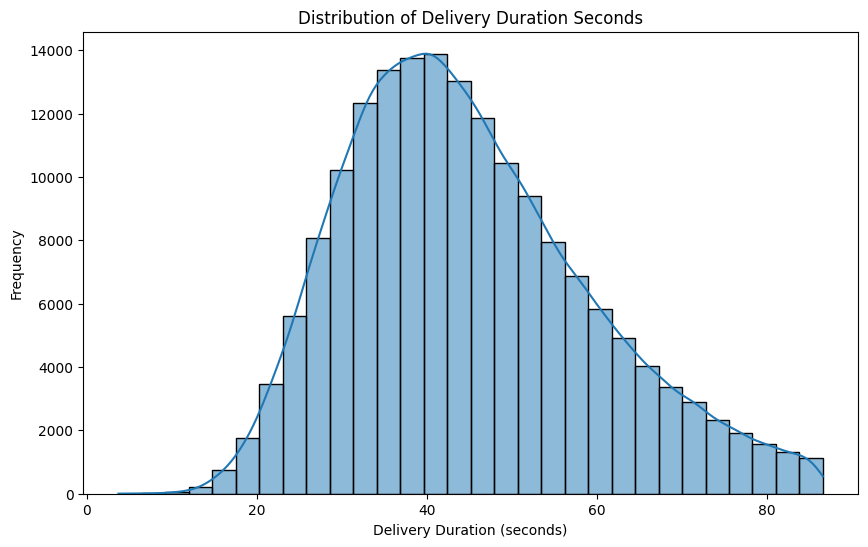

<Figure size 1500x1000 with 0 Axes>

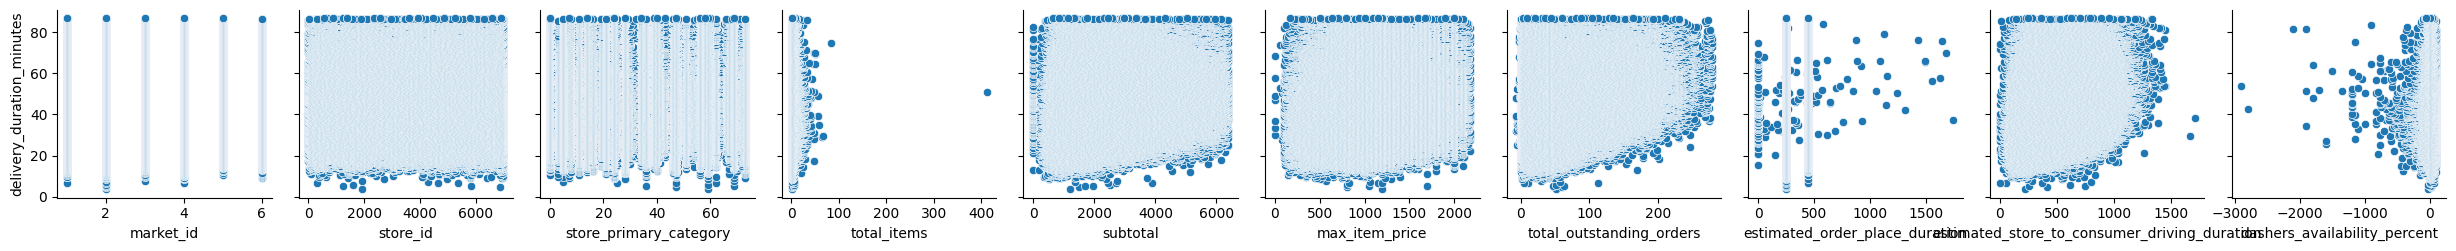

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned data
data = pd.read_csv('cleaned_data.csv')

# Plot the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(data['delivery_duration_minutes'], bins=30, kde=True)
plt.title('Distribution of Delivery Duration Seconds')
plt.xlabel('Delivery Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

# Plot relationships between numerical features and target
plt.figure(figsize=(15, 10))
sns.pairplot(data, y_vars='delivery_duration_minutes', x_vars=numerical_features)
plt.show()


#Model Training and Evaluation

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# Function to evaluate polynomial regression models
def evaluate_polynomial_regression(degree):
    polynomial_features = PolynomialFeatures(degree=degree)
    X_train_poly = polynomial_features.fit_transform(X_train)
    X_test_poly = polynomial_features.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)

    print(f"Degree {degree}")
    print(f"Train RMSE: {mean_squared_error(y_train, y_train_pred, squared=False)}")
    print(f"Train R2: {r2_score(y_train, y_train_pred)}")
    print(f"Test RMSE: {mean_squared_error(y_test, y_test_pred, squared=False)}")
    print(f"Test R2: {r2_score(y_test, y_test_pred)}")
    print("\n")

# Evaluate models with degrees 1, 2, 3, and 4
for degree in [1, 2, 3, 4]:
    evaluate_polynomial_regression(degree)


Degree 1
Train RMSE: 13.208746010564289
Train R2: 0.15964168136411783
Test RMSE: 13.19214075674234
Test R2: 0.16123356054910576


Degree 2
Train RMSE: 13.035295815367991
Train R2: 0.18156704672458646
Test RMSE: 13.023834549650584
Test R2: 0.1824991117734166


Degree 3
Train RMSE: 12.901921327994746
Train R2: 0.19822944327483794
Test RMSE: 12.974031954802712
Test R2: 0.18873933567951895


Degree 4
Train RMSE: 12.75626563738933
Train R2: 0.21623036515048677
Test RMSE: 14.487590763398577
Test R2: -0.011586050445762996




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.60582e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


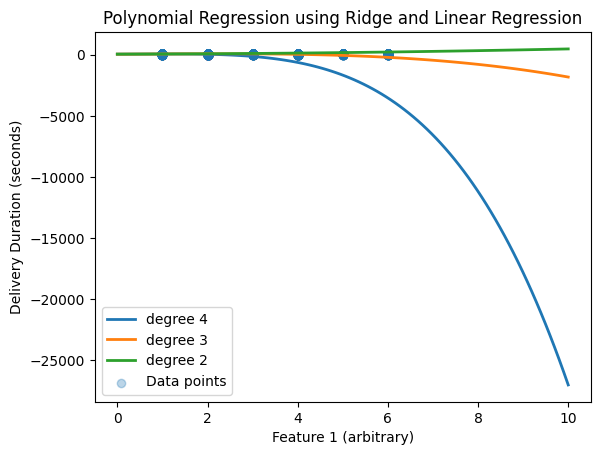

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LinearRegression
import matplotlib.pyplot as plt


x_plot = np.linspace(0, 10, 100).reshape(-1, 1)

# Fit polynomial regression models
poly1 = make_pipeline(PolynomialFeatures(2), Ridge()) # degree 2
poly1.fit(X_train, y_train)
y_plot1 = poly1.predict(np.hstack([x_plot]*10))

poly2 = make_pipeline(PolynomialFeatures(3), LinearRegression()) # degree 3
poly2.fit(X_train, y_train)
y_plot2 = poly2.predict(np.hstack([x_plot]*10))

poly3 = make_pipeline(PolynomialFeatures(4), Ridge()) # degree 4
poly3.fit(X_train, y_train)
y_plot3 = poly3.predict(np.hstack([x_plot]*10))

# Plot the results
plt.plot(x_plot, y_plot3, linewidth=2, label="degree 4")
plt.plot(x_plot, y_plot2, linewidth=2, label="degree 3")
plt.plot(x_plot, y_plot1, linewidth=2, label="degree 2")
plt.scatter(X.iloc[:, 0], y, alpha=0.3, label='Data points')
plt.title('Polynomial Regression using Ridge and Linear Regression')
plt.xlabel('Feature 1 (arbitrary)')
plt.ylabel('Delivery Duration (seconds)')
plt.legend(loc='lower left')
plt.show()
